In [1]:
# Install the library for the F1 developer API: http://ergast.com/mrd/
!python -m pip install pyergast

In [2]:
# Import the necessary libraries
import requests
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import timedelta
from pyergast import pyergast
import os
%matplotlib inline

In [3]:
# Function for Driver to the corresponding colour
def assign_color(val_type, values):
    cl = []
    for val in values:
        if val_type == 'drivers':  abbr = val.split()[1].upper()[0:3]
        elif val_type == 'teams':  abbr = val[0:4].upper()
        
        if abbr in ['ALFA','RÄI','GIO']:         cl.append('#960000')
        elif abbr in ['HAAS','GRO','MAG','FIT']: cl.append('#787878')
        elif abbr in ['RACI','PÉR','STR','HÜL']: cl.append('#f595c8')
        elif abbr in ['WILL','RUS','LAT','AIT']: cl.append('#0082fa')
        elif abbr in ['ALPH','GAS','KVY']:       cl.append('#ffffff')
        elif abbr in ['MCLA','SAI','NOR']:       cl.append('#ff8700')
        elif abbr in ['RED ','VER','ALB']:       cl.append('#0600f0')
        elif abbr in ['FERR','LEC','VET']:       cl.append('#cb0000')
        elif abbr in ['MERC','HAM','BOT']:       cl.append('#00d2b5')
        elif abbr in ['RENA','RIC','OCO']:       cl.append('#fff500')
    return cl

In [4]:
# Call http://ergast.com/mrd/ to get the fastest lap, because pyergast doesn't support it
def get_fastest_lap(year, race):
    assert year and race, 'You must specify both a year and a race for the fastest lap function'
    url = f"https://ergast.com/api/f1/{year}/{race}/fastest/1/results.json?limit=1000"
    
    r = requests.get(url)
    assert r.status_code == 200, 'Cannot connect to Ergast API. Check your inputs.'
    fastest_lap = r.json()
    driver_no = fastest_lap["MRData"]['RaceTable']['Races'][0]['Results'][0]["number"]
    return driver_no

In [5]:
# Helper functions to load the pandas Dataframes
def get_calendar(season):
    scheduleFileName = "calendar.csv"
    if os.path.exists(scheduleFileName):
        # print(f"The {scheduleFileName} file is already present!")
        schedule = pd.read_csv(scheduleFileName)
        schedule.drop(["Unnamed: 0"], axis=1, inplace=True)
    else:
        schedule = pyergast.get_schedule(year=season)
        schedule.to_csv(scheduleFileName)
    
    return schedule

def get_results(season):
    schedule = get_calendar(season=season)
    resultsFileName = "raceResults.csv"
    if os.path.exists(resultsFileName):
        # print(f"The {resultsFileName} file is already present!")
        currRaceResults = pd.read_csv(resultsFileName)
        currRaceResults.drop(["Unnamed: 0"], axis=1, inplace=True)
    else:
        for index, row in schedule.iterrows():
            currRaceResults = pyergast.get_race_result(year=season, race=row["round"])
            
            currRaceResults.set_index("number", inplace=True)
            fastestDriver = str(get_fastest_lap(year=season, race=row["round"]))
            currRaceResults["Fastest lap"] = ["NO"] * len(currRaceResults)
            currRaceResults.loc[fastestDriver, "Fastest lap"] = "YES"
            currRaceResults.reset_index(inplace=True)
            currRaceResults["raceName"] = [row["raceName"]] * len(currRaceResults)

            currRaceResults.drop(["positionText", "driverID", "nationality", "constructorID"], axis=1, inplace=True)
            currRaceResults.rename(columns={"grid": "Qualified"}, inplace=True)

            cols = currRaceResults.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            currRaceResults = currRaceResults[cols]
            hdr = False  if os.path.isfile(resultsFileName) else True
            currRaceResults.to_csv(resultsFileName, mode='a', header=hdr)
    
    return currRaceResults

In [6]:
# Create or read the files for the Season Analysis
season = 2020
calendar = get_calendar(season=season)
raceResults = get_results(season=season)

In [7]:
# Get the Grand Prix Winners
def get_time(data):
    for index, row in data.items():
        rowDict = ast.literal_eval(row)
        data[index] = rowDict["time"]
    return

winners = raceResults[raceResults["position"] == 1].reset_index().drop(["points", "position", "laps", "index", "status", "number"], axis=1)
winners = winners.rename(columns={"raceName": "Track", "driver": "Driver", "constructor": "Constructor"})
get_time(winners["Time"])

col = ["Track", "Driver", "Constructor", "Time", "Fastest lap", "Qualified"]
winners = winners[col]
winners.set_index("Track", inplace=True)
winners

C:\Users\user\AppData\Local\Temp\ipykernel_3388\1523307465.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[index] = rowDict["time"]


,Driver,Constructor,Time,Fastest lap,Qualified
Track,,,,,
Austrian Grand Prix,Valtteri Bottas,Mercedes,1:30:55.739,NO,1
Styrian Grand Prix,Lewis Hamilton,Mercedes,1:22:50.683,NO,1
Hungarian Grand Prix,Lewis Hamilton,Mercedes,1:36:12.473,YES,1
British Grand Prix,Lewis Hamilton,Mercedes,1:28:01.283,NO,1
70th Anniversary Grand Prix,Max Verstappen,Red Bull,1:19:41.993,NO,4
Spanish Grand Prix,Lewis Hamilton,Mercedes,1:31:45.279,NO,1
Belgian Grand Prix,Lewis Hamilton,Mercedes,1:24:08.761,NO,1
Italian Grand Prix,Pierre Gasly,AlphaTauri,1:47:06.056,NO,10
Tuscan Grand Prix,Lewis Hamilton,Mercedes,2:19:35.060,YES,1


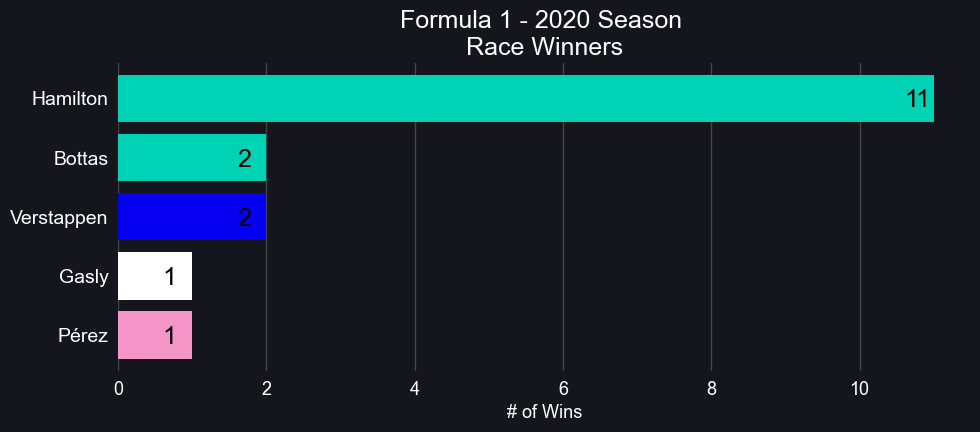

In [8]:
# Same information on a plot
winnerCnt = winners['Driver'].value_counts()
plt.style.use('seaborn-v0_8')
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = '#15151e'
plt.rcParams['figure.facecolor'] = '#15151e'
plt.rcParams['grid.color'] = '#444444'
c = assign_color('drivers', winnerCnt.index)
plt.figure(figsize=(11,4))
plt.barh([driver.split()[1] for driver in winnerCnt.index], winnerCnt.values, color=c)
for i in range(len(winnerCnt.values)):
    plt.text(winnerCnt.values[i] - 0.4, i + 0.15, winnerCnt.values[i], color='k', fontsize=18)

plt.axis([0, max(winnerCnt.values) + 0.5, len(winnerCnt) - 0.4, -0.6])
plt.title(f"Formula 1 - {season} Season \nRace Winners", fontsize=18)
plt.xlabel("# of Wins", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.show()

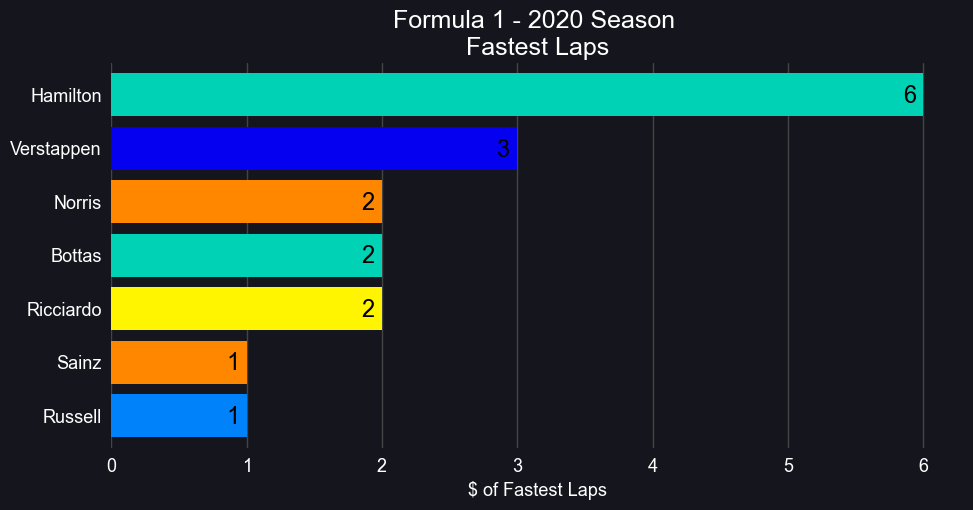

In [9]:
# Get the drivers with the Fastest Laps
fastestLaps = raceResults[raceResults['Fastest lap'] == 'YES'].rename(columns={'position':'Finish Position', "driver": "Driver", "constructor": "Constructor"})
fastestLaps.set_index('raceName')
fastestLapCnt = fastestLaps['Driver'].value_counts()
c = assign_color('drivers', fastestLapCnt.index)
plt.figure(figsize=(11,5))
plt.barh([driver.split()[1] for driver in fastestLapCnt.index], fastestLapCnt.values, color=c)
for i in range(len(fastestLapCnt.values)):
    plt.text(fastestLapCnt.values[i] - 0.15, i + 0.15, fastestLapCnt.values[i], color='k', fontsize=17)

plt.axis([0, max(fastestLapCnt.values) + 0.3, len(fastestLapCnt) - 0.4, -0.6])
plt.title(f"Formula 1 - {season} Season \nFastest Laps", fontsize=18)
plt.xlabel("$ of Fastest Laps", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis='y')
plt.show()

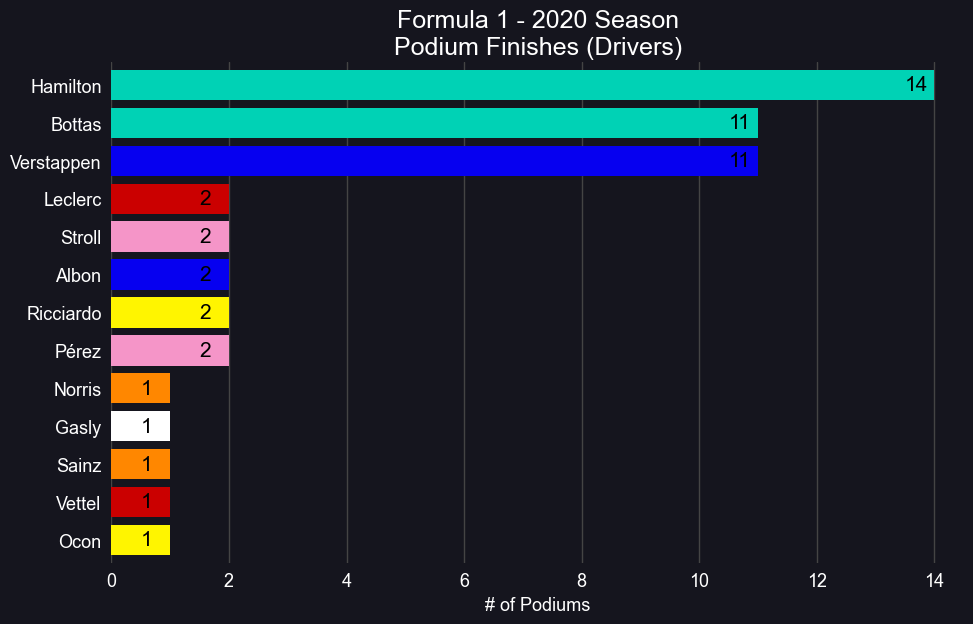

In [10]:
# Count the Drivers podiums
podiums = raceResults[raceResults['position'].isin([1, 2, 3])]
podiumsCnt = podiums['driver'].value_counts()
c = assign_color('drivers', podiumsCnt.index)
plt.figure(figsize=(11,6.5))
plt.barh([driver.split()[1] for driver in podiumsCnt.index], podiumsCnt.values, color=c)
for i in range(len(podiumsCnt.values)):
    plt.text(podiumsCnt.values[i] - 0.5, i + 0.15, podiumsCnt.values[i], color='k', fontsize=15)

plt.axis([0, max(podiumsCnt) + 0.5, len(podiumsCnt) - 0.4, -0.6])
plt.title(f"Formula 1 - {season} Season\nPodium Finishes (Drivers)", fontsize=18)
plt.xlabel("# of Podiums", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis='y')
plt.show()

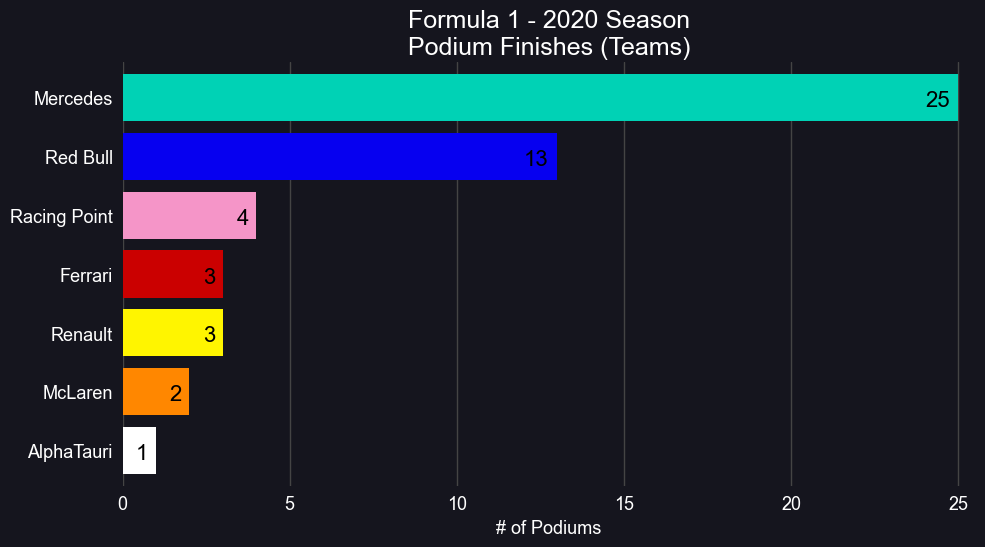

In [11]:
# Count the Constructors podiums
podiumsCntTeam = podiums['constructor'].value_counts()
c = assign_color('teams', podiumsCntTeam.index)
plt.figure(figsize=(11,5.5))
plt.barh(podiumsCntTeam.index, podiumsCntTeam.values, color=c)
for i in range(len(podiumsCntTeam.values)):
    if podiumsCntTeam.values[i] >= 10:  sh = 1
    else:   sh = 0.6
    plt.text(podiumsCntTeam.values[i] - sh, i + 0.15, podiumsCntTeam.values[i], color='k', fontsize=16)

plt.axis([0,max(podiumsCntTeam.values) + 0.5,len(podiumsCntTeam) - 0.4, -0.6])
plt.title(f"Formula 1 - {season} Season\nPodium Finishes (Teams)", fontsize=18)
plt.xlabel(f"# of Podiums", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis='y')
plt.show()

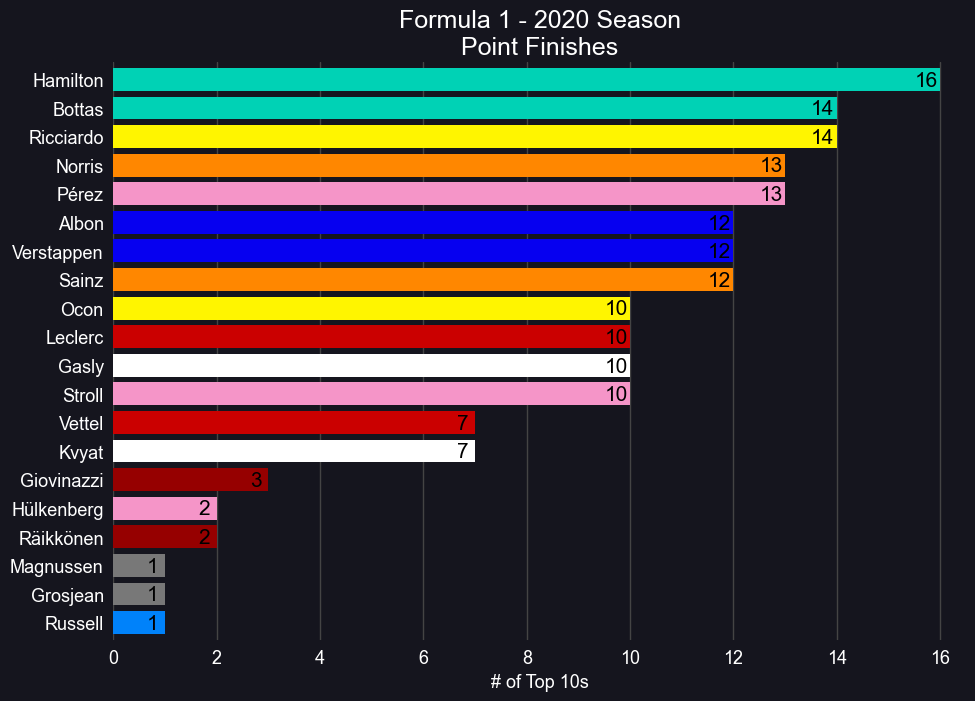

In [12]:
# Count the Drivers point finishes
top10 = range(1,11)
topTenFinishes = raceResults[raceResults['position'].isin(top10)]['driver'].value_counts()
c = assign_color('drivers',topTenFinishes.index)
plt.figure(figsize=(11, 7.5))
plt.barh([driver.split()[1] for driver in topTenFinishes.index], topTenFinishes.values, color=c)
for i in range(len(topTenFinishes.values)):
    if topTenFinishes.values[i] >= 10:  sh = 0.5
    else:   sh = 0.35
    plt.text(topTenFinishes.values[i] - sh, i + 0.23, topTenFinishes.values[i], color='k', fontsize=15)

plt.axis([0, max(topTenFinishes.values) + 0.5, len(topTenFinishes) - 0.4, -0.6])
plt.title(f"Formula 1 - {season} Season\nPoint Finishes", fontsize=18)
plt.xlabel("# of Top 10s", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis='y')
plt.show()

In [13]:
# Driver Standings
driverStandings = raceResults.groupby(["driver", "constructor"])['points'].sum().sort_values(ascending=False)
driverStandings = driverStandings.reset_index()
driverStandings.rename(columns={"driver": "Driver", "constructor": "Constructor", "points": "Points"}, inplace=True)
driverStandings["Position"] = range(1, len(driverStandings) + 1)
driverStandings.set_index("Position", inplace=True)
driverStandings

,Driver,Constructor,Points
Position,,,
1,Lewis Hamilton,Mercedes,347
2,Valtteri Bottas,Mercedes,223
3,Max Verstappen,Red Bull,214
4,Sergio Pérez,Racing Point,125
5,Daniel Ricciardo,Renault,119
6,Alexander Albon,Red Bull,105
7,Carlos Sainz,McLaren,105
8,Charles Leclerc,Ferrari,98
9,Lando Norris,McLaren,97


In [14]:
# Constructor Standings
constructorStandings = raceResults.groupby(["constructor"])['points'].sum()
constructorStandings.loc["Racing Point"] -= 15 # Penalty enforced in August
constructorStandings = constructorStandings.sort_values(ascending=False).reset_index()
constructorStandings.rename(columns={"constructor": "Constructor", "points": "Points"}, inplace=True)
constructorStandings["Position"] = range(1, len(constructorStandings) + 1)
constructorStandings.set_index("Position", inplace=True)
constructorStandings

,Constructor,Points
Position,,
1,Mercedes,573
2,Red Bull,319
3,McLaren,202
4,Racing Point,195
5,Renault,181
6,Ferrari,131
7,AlphaTauri,107
8,Alfa Romeo,8
9,Haas F1 Team,3


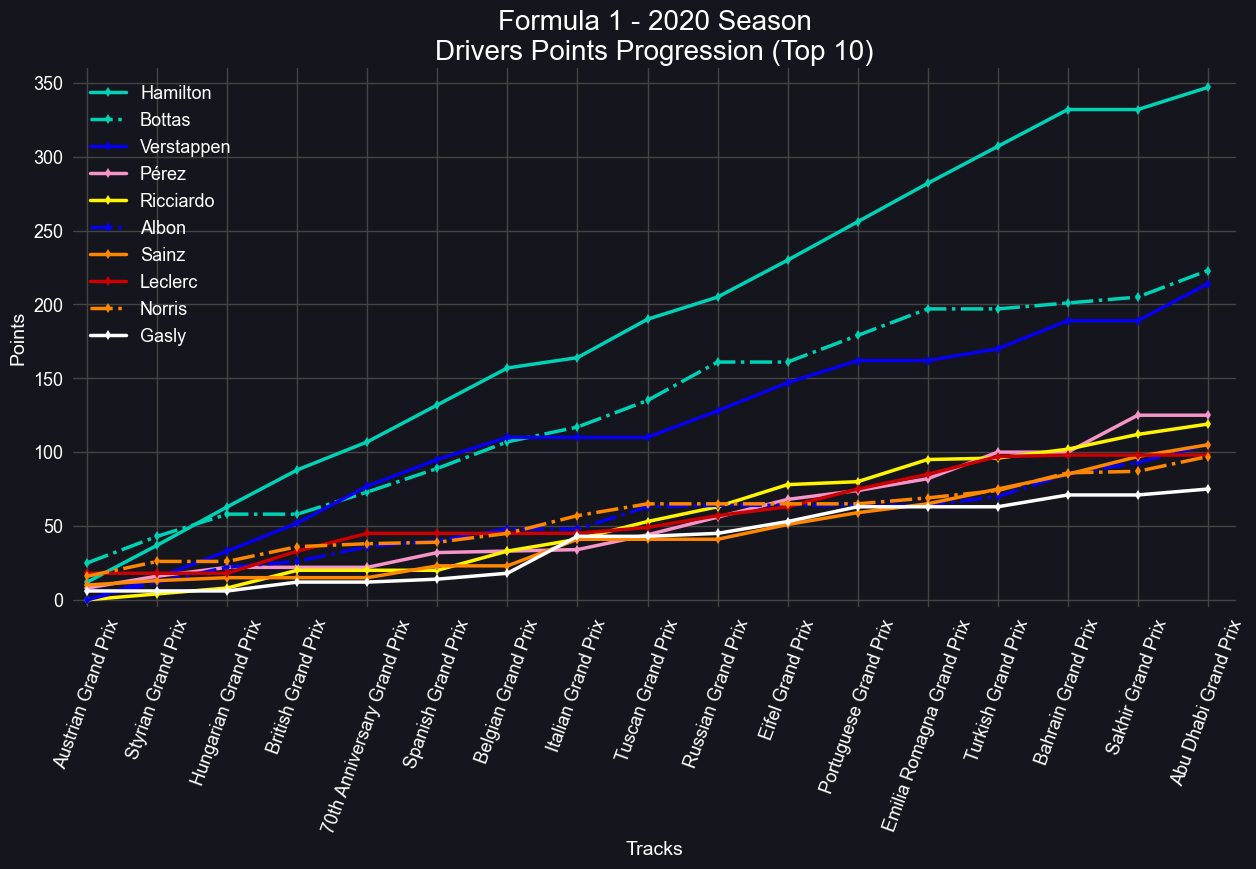

In [15]:
# Drivers Points Progression (Top 10)
GPnames = raceResults['raceName'].unique()
TopTenDrivers = driverStandings.head(10)['Driver'].values
color = assign_color('drivers', TopTenDrivers)
abbr = [driver.split()[1] for driver in TopTenDrivers]
plt.figure(figsize=(15,7))
for i in range(len(TopTenDrivers)):
    ptsPrg = raceResults[raceResults['driver'] == TopTenDrivers[i]]['points'].cumsum().values
    for j in range(len(GPnames)):
        if TopTenDrivers[i] not in raceResults[raceResults['raceName'] == GPnames[j]]['driver'].values:
            ptsPrg = np.insert(ptsPrg, j-1, ptsPrg[j-1])
    if abbr[i].upper()[0:3] in ['BOT','ALB','NOR']:
        plt.plot(ptsPrg, color=color[i], label=abbr[i], marker='d', markersize=5, linestyle='-.', linewidth=2.5)
    else:  plt.plot(ptsPrg, color=color[i], label=abbr[i], marker='d', markersize=5, linewidth=2.5)

plt.axis([-0.2,16.4,-5,360])
plt.title(f"Formula 1 - {season} Season\nDrivers Points Progression (Top 10)", fontsize=20)
plt.xlabel("Tracks", fontsize=14)
plt.xticks(range(17), GPnames, rotation=70, fontsize=13)
plt.ylabel("Points", fontsize=14)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.show()

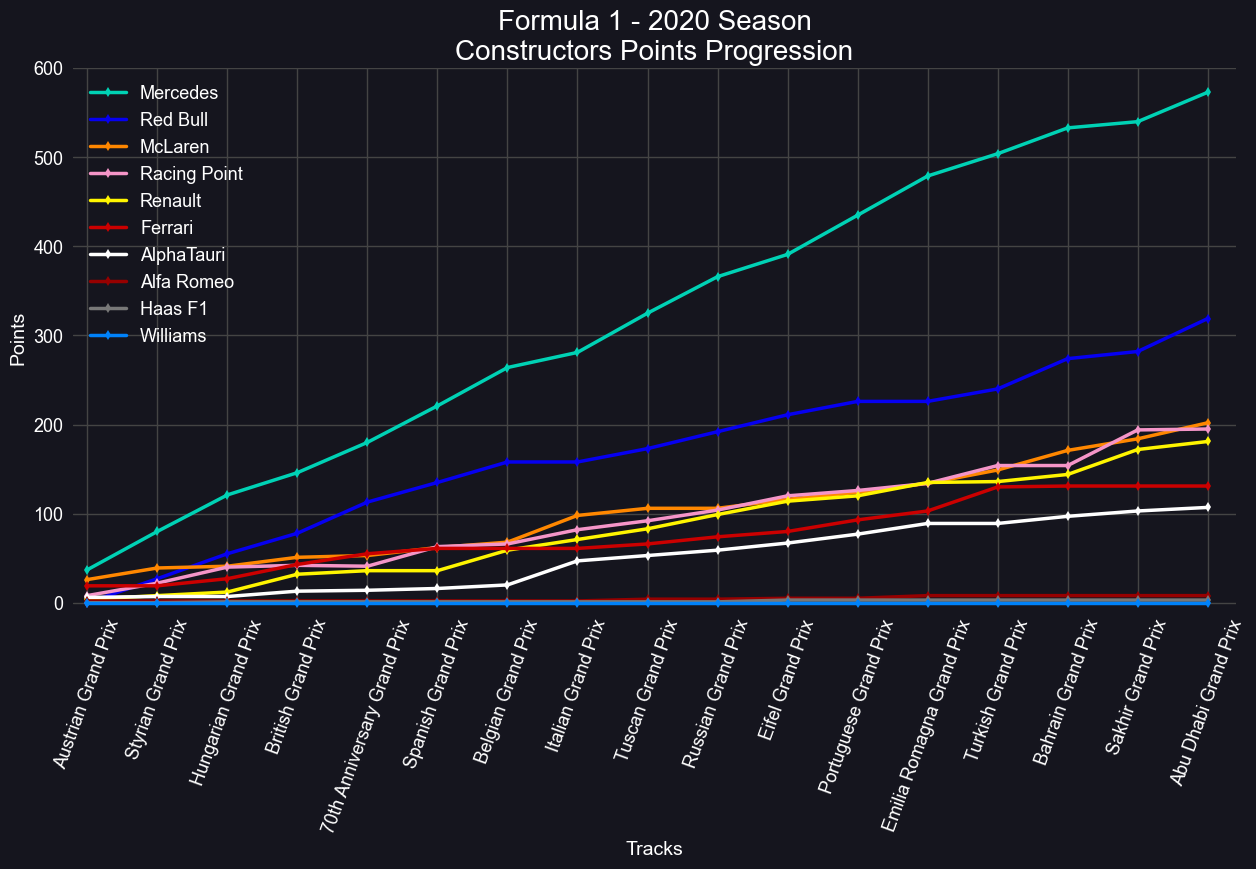

In [16]:
# Constructors Points Progression (Top 10)
trackTeamPts = raceResults.groupby(['raceName','constructor'])['points'].agg('sum')
trackTeamPts.loc[('70th Anniversary Grand Prix','Racing Point')] -= 15
trackOrder = raceResults['raceName'].unique()
teamOrder = constructorStandings['Constructor'].unique()
color = assign_color('teams',teamOrder)
abbr = [" ".join(team.split()[0:2]) for team in teamOrder]
plt.figure(figsize=(15,7))
for i in range(len(teamOrder)):
    teamPts = []
    for j in range(len(trackOrder)):
        teamPts.append(trackTeamPts.loc[(trackOrder[j], teamOrder[i])])

    teamPts = np.array(teamPts).cumsum()
    plt.plot(teamPts, color=color[i], label=abbr[i], marker='d', markersize=5, linewidth=2.5)

plt.title(f"Formula 1 - {season} Season\nConstructors Points Progression", fontsize=20)
plt.axis([-0.2,16.4,-5,600])
plt.xlabel('Tracks', fontsize=14)
plt.xticks(range(17), trackOrder, rotation=70, fontsize=13)
plt.ylabel('Points', fontsize=14)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.show()

Total of 57 DNFs have occurred.


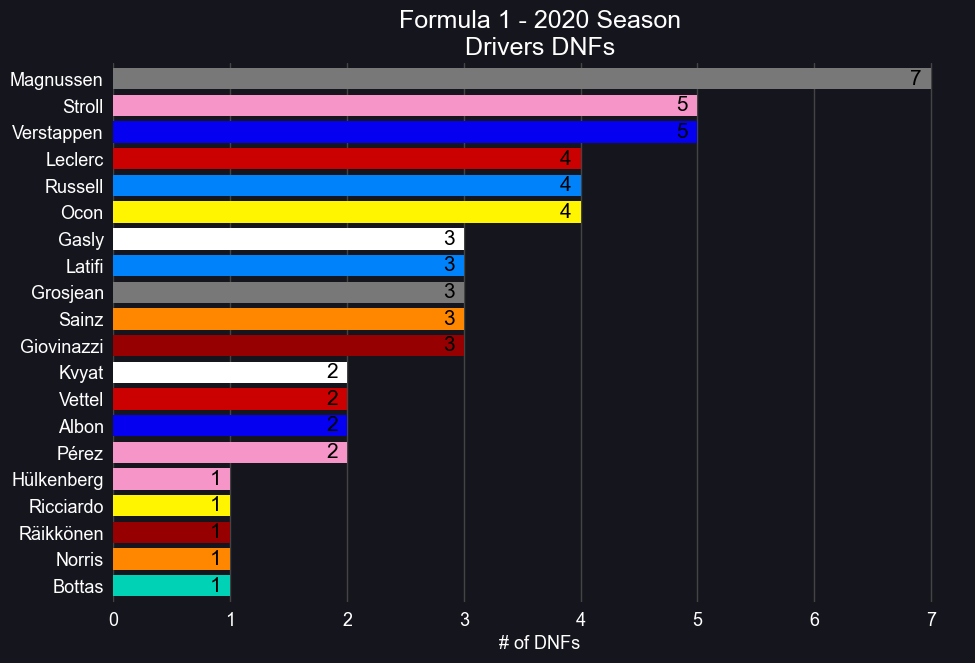

In [17]:
# Drivers DNFs
DNF = raceResults[((raceResults['status'] != 'Finished') & (raceResults['status'] != '+1 Lap') 
                  & (raceResults['status'] != '+2 Laps') & (raceResults['status'] != '+5 Laps'))]
print("Total of {} DNFs have occurred.".format(DNF.shape[0]))
DNFdriver = DNF['driver'].value_counts()
c = assign_color('drivers',DNFdriver.index)
plt.figure(figsize=(11,7))
plt.barh([driver.split()[1] for driver in DNFdriver.index], DNFdriver.values, color=c)
for i in range(len(DNFdriver.values)):
    plt.text(DNFdriver.values[i] - 0.18, i + 0.21, DNFdriver.values[i], color='k', fontsize=15)
plt.axis([0,max(DNFdriver.values) + 0.3, len(DNFdriver) - 0.4, -0.6])
plt.title(f"Formula 1 - {season} Season\nDrivers DNFs", fontsize=18)
plt.xlabel("# of DNFs", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis='y')
plt.show()